# Week 9 Workshop
In this workshop, we're exploring some of the DSP tools that we covered in the week 8 lessons.  

## Exercise 1: Identify and mitigate spectral leakage
One of the most siginificant artefacts caused by analysing finite signals with tools that assume statistical stationarity/uniformity is *spectral leakage*. Here, we'll work to identify and mitigate this effect. 

### Part 1: Generate sine waves and look at the resulting spectra

Power at 30.0 Hz: 0.5
Power at 29.0 Hz: 1.6404455488529088e-15
Power at 31.0 Hz: 1.7051700001055944e-15


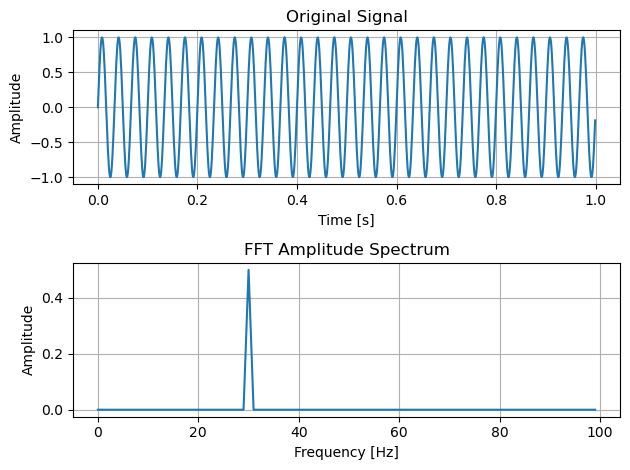

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling frequency (Hz)
N = 1000    # Number of samples
f = 30     # Signal frequency (not aligned with FFT bins)

t = np.arange(N) / fs # time vector

# Generate a sine wave
signal = np.sin(2 * np.pi * f * t)

# Compute the FFT and amplitude spectrum
fft_result = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, d=1/fs)
amplitude_spectrum = np.abs(fft_result) / N

# print the power when freq == f, and the power in the bins before and after
freq_index = np.argmin(np.abs(freqs - f))
print(f"Power at {freqs[freq_index]} Hz: {amplitude_spectrum[freq_index]}")
print(f"Power at {freqs[freq_index-1]} Hz: {amplitude_spectrum[freq_index-1]}")
print(f"Power at {freqs[freq_index+1]} Hz: {amplitude_spectrum[freq_index+1]}")

plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(freqs[:N//10], amplitude_spectrum[:N//10])
plt.title('FFT Amplitude Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()



### Step 2: Apply Hann and Hamming Windows 
- try varying the window Type
- try varying the window Duration

Window: Rectangular
Power at 30.0 Hz: 0.5
Power at 29.0 Hz: 1.6404455488529088e-15
Power at 31.0 Hz: 1.7051700001055944e-15
Window: Hamming
Power at 30.0 Hz: 0.26976993747669015
Power at 29.0 Hz: 0.11505740417679887
Power at 31.0 Hz: 0.11505739997962743
Window: Hann
Power at 30.0 Hz: 0.24974993203988066
Power at 29.0 Hz: 0.12506239584434647
Power at 31.0 Hz: 0.12506239128220387


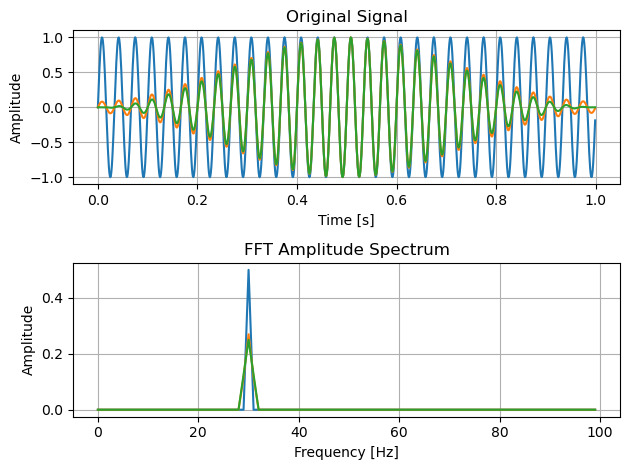

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows

# Parameters
fs = 1000  # Sampling frequency (Hz)
N = 1000    # Number of samples
f = 30     # Signal frequency (not aligned with FFT bins)

t = np.arange(N) / fs # time vector

# Generate a sine wave
signal = np.sin(2 * np.pi * f * t)

windows_dict = {
    "Rectangular": np.ones(N),
    "Hamming": windows.hamming(N),
    "Hann": windows.hann(N)
}

for i, (name, window) in enumerate(windows_dict.items(), 1):
    windowed_signal = signal * window
    fft_result = np.fft.fft(windowed_signal)
    freqs = np.fft.fftfreq(N, d=1/fs)
    magnitude = np.abs(fft_result) / N
    freqs = freqs[:N//2]

    # print the power when freq == f, and the power in the bins before and after
    freq_index = np.argmin(np.abs(freqs - f))
    print(f"Window: {name}")
    print(f"Power at {freqs[freq_index]} Hz: {magnitude[freq_index]}")
    print(f"Power at {freqs[freq_index-1]} Hz: {magnitude[freq_index-1]}")
    print(f"Power at {freqs[freq_index+1]} Hz: {magnitude[freq_index+1]}")

    plt.subplot(2, 1, 1)
    plt.plot(t, windowed_signal)
    plt.title('Original Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(freqs[:N//10],magnitude[:N//10])
    plt.title('FFT Amplitude Spectrum')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    
plt.grid()
plt.tight_layout()
plt.show()

## Exercise 2 : Wavelets for Event Localisation
You can use a wavelet transform rather than a FFT if you want to find specific frequency information at a particular localised time. Let's have a look at an event localisation exercise. To do this your're going to need to install PyWavelets e.g. `conda install pywavelets`. 

<Figure size 1000x600 with 0 Axes>

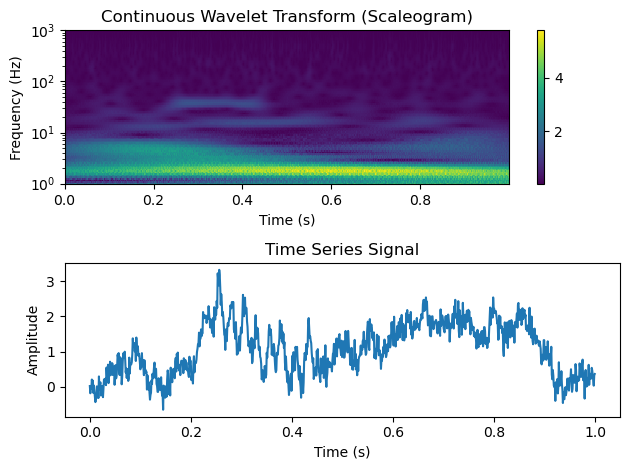

In [70]:
import pywt

# Choose wavelet and scales
wavelet = 'cmor1.5-1.0'  # Complex Morlet (good for frequency localization)
# cmorB-C is a complex Morlet wavelet with bandwidth B and center frequency C


#==== Simulated Signal
# Time vector
fs = 1000  # Sampling rate in Hz
t = np.linspace(0, 1, fs, endpoint=False)
sampling_period = 1/fs  # Sampling period in seconds

brownian_noise = np.cumsum(np.random.normal(0, 1, len(t)))
white_noise = np.random.randn(len(t))
signal = 0.2 * white_noise + 0.1 * brownian_noise

onTime = 0.25; duration = 0.2;

# get a logical mask for the time vector for t > onTime & t < onTime + duration
t_mask = (t > onTime) & (t < onTime + duration)

signal[t_mask] += np.sin(2 * np.pi * 40 * t[t_mask])*0.5  

# Apply CWT
widths = np.geomspace(1, 1024, num=100)
coefficients, frequencies = pywt.cwt(signal, widths, wavelet, sampling_period=sampling_period)

# Plot scalogram
plt.figure(figsize=(10, 6))
fig, axs = plt.subplots(2, 1)

# plot result using matplotlib's pcolormesh (image with annoted axes)
cwtmatr = np.abs(coefficients[:-1, :-1])
pcm = axs[0].pcolormesh(t, frequencies, cwtmatr)

axs[0].set_yscale("log")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

axs[1].plot(t, signal)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")
axs[1].set_title("Time Series Signal")

plt.tight_layout()
plt.show()
